# Time series analysis - Example code 14: A bit more on linear prediction

**Lund University, Lund, Sweden**

**Reference:**  
"An Introduction to Time Series Modeling", 4th ed, by Andreas Jakobsson  
Studentlitteratur, 2021

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter

import sys
sys.path.append('../TimeSeriesAnalysis-main/TimeSeriesAnalysis-main')

from tsa_lth.modelling import estimateARMA
from tsa_lth.analysis import acf
from tsa_lth.tests import whiteness_test
from tsa_lth.tools.poly import polydiv

## Simulate some processes

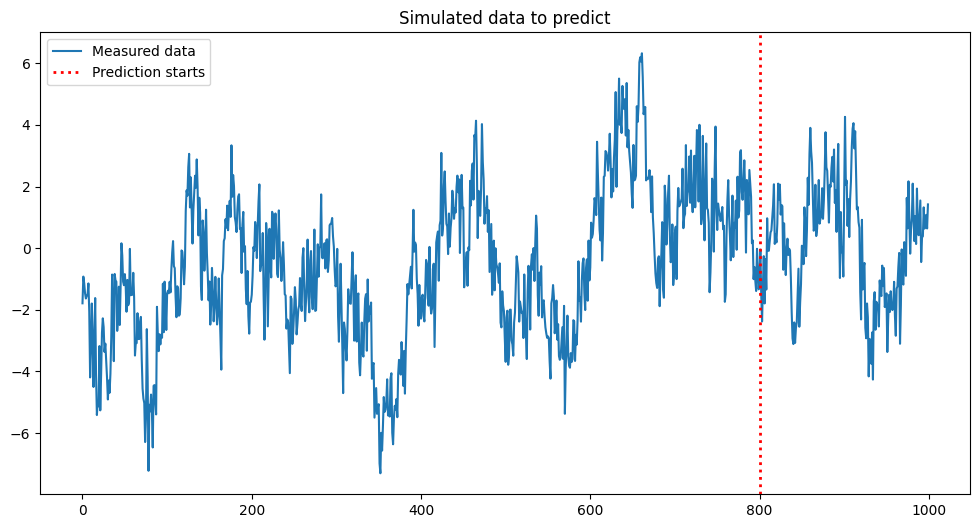

In [2]:
noLags = 40
extraN = 100
pstart = 800                                    # Start the prediction at this sample.
np.random.seed(50)                               # Set the seed (just done for the lecture!)
N = 1000                                        # Try reducing the number of samples.
C = np.array([1, -0.6, 0.5])                    # Try other polynomials.
A = np.convolve([1, -0.96], [1, -0.2, 0.6])
data = lfilter(C, A, np.random.randn(N + extraN))
data = data[extraN:]

plt.figure(figsize=(12, 6))
plt.plot(data)
plt.axvline(x=pstart, color='red', linestyle=':', linewidth=2)
plt.legend(['Measured data', 'Prediction starts'], loc='upper left')
plt.title('Simulated data to predict')
plt.show()

## Part 1: Form the prediction using the true polynomials

These are of course not known, but when examining an issue, you want to have as few complicating factors as possible.

In [3]:
k = 4                                           # Try varying k, say k=3.
F, G = polydiv(C, A, k)                         # Compute the G and F polynomials.
print(f"F = {F}")
print(f"G = {G}")
yhatk = lfilter(G, C, data)                     # Form the predicted data.

F = [1.       0.56     0.3576   0.547296]
G = [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.11022302e-16
  6.74204160e-01 -2.27480832e-01  3.15242496e-01]


## Plot the prediction

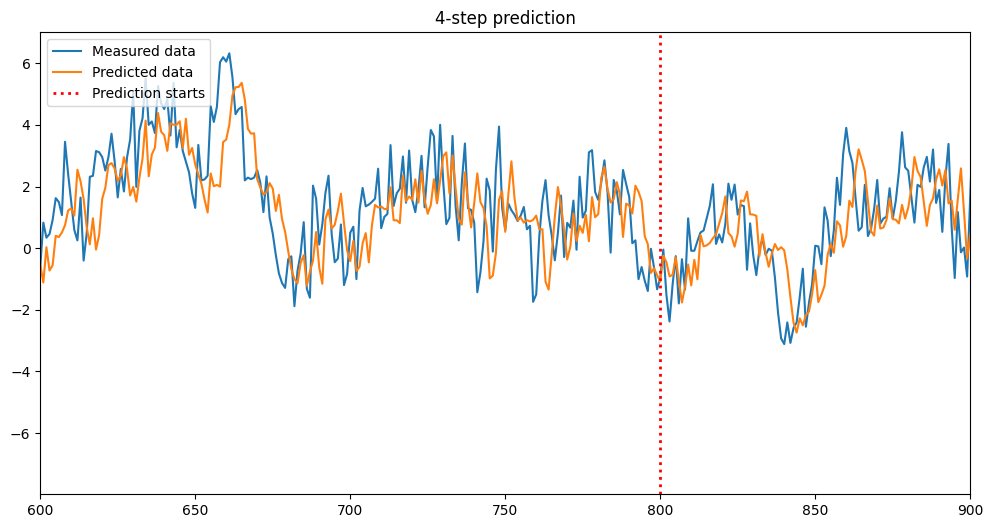

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(data, label='Measured data')
plt.plot(yhatk, label='Predicted data')
plt.axvline(x=pstart, color='red', linestyle=':', linewidth=2, label='Prediction starts')
plt.xlim([600, 900])
plt.title(f'{k}-step prediction')
plt.legend(loc='upper left')
plt.show()

## Form the residual. Is it behaving as expected?

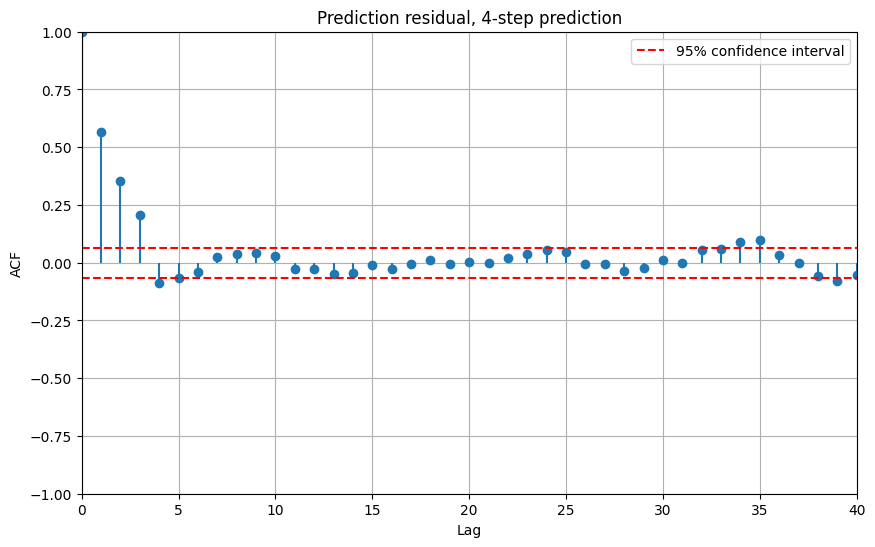

This is a 4-step prediction. Ideally, the residual should be an MA(3) process.
Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: False (white if 473.41 < 37.65)
  McLeod-Li test:        False (white if 119.47 < 37.65)
  Monti test:            False (white if 447.78 < 37.65)
  Sign change test:      False (white if 0.31 in [0.47,0.53])


In [5]:
ehat = data - yhatk
ehat = ehat[100+1:]

plt.figure(figsize=(10, 6))
acfEst = acf(ehat, noLags)
plt.stem(range(len(acfEst)), acfEst, basefmt=' ')

# Confidence interval
conf_int = 1.96 / np.sqrt(len(ehat))
plt.axhline(y=conf_int, color='r', linestyle='--', label='95% confidence interval')
plt.axhline(y=-conf_int, color='r', linestyle='--')

plt.xlim([0, noLags])
plt.ylim([-1, 1])
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.title(f'Prediction residual, {k}-step prediction')
plt.legend()
plt.grid(True)
plt.show()

print(f'This is a {k}-step prediction. Ideally, the residual should be an MA({k-1}) process.')
whiteness_test(ehat)

## Part 2: Let's try to predict the future, as if it was not known (this is actually often the case :-)

Predict the future values, i.e., form the prediction for k=1, 2, 3, ...

Discrete-time ARMA model: A(z)y(t) = C(z)e(t)

A(z) = 1.0 - 1.2054(±0.0856)·z⁻¹ + 0.8202(±0.1061)·z⁻² - 0.5574(±0.048)·z⁻³
C(z) = 1.0 - 0.5907(±0.0917)·z⁻¹ + 0.4768(±0.0716)·z⁻²

Polynomial orders: nA = 3    nC = 2
Number of free coefficients: 5
Fit to estimation data (NRMSE): 56.53%
FPE : 1.015  MSE : 1.006
AIC : 2845.452   BIC : 2869.975



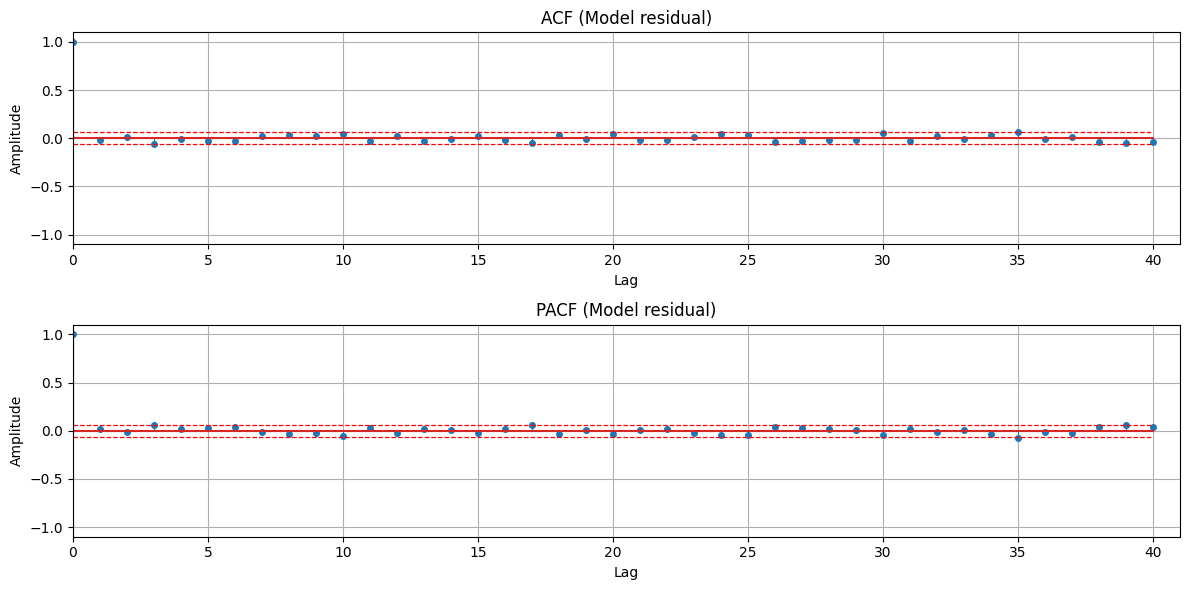

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 23.06 < 37.65)
  McLeod-Li test:        True (white if 34.25 < 37.65)
  Monti test:            True (white if 23.87 < 37.65)
  Sign change test:      True (white if 0.51 in [0.47,0.53])


In [6]:
# Begin with estimating the model - to simplify, we use the true model.
foundModel = estimateARMA(data, A=A, C=C, titleStr='Model residual', noLags=noLags)
ey = foundModel.resid
q = len(foundModel.C)

In [7]:
# We proceed to form the predictions, one for each k.
kMax = 20                                       # How far ahead do we wish to predict.
pred_yk = data[:pstart-1].copy()                # This is the predicted vector; it is known up to the start of the prediction.
var_yk = np.zeros(pstart + kMax)                # This is the variance of the prediction; the variance is zero up to the start of the prediction.
var_et = np.var(ey, ddof=0)                     # Estimate the noise variance using the model residual.

for k in range(1, kMax + 1):
    # Compute the prediction polynomials.
    F, G = polydiv(foundModel.C, foundModel.A, k)
    
    # Form the prediction - note that you have to use the earlier predicted
    # values, not the true values, for the C \hat{y}_{t+1|t} part. It is
    # easy to get errors on this part. Use simulate data to check, at first
    # using C=1.
    
    # This is G y_t. Note that you have to reverse the time order.
    G_term = np.dot(G, data[pstart-2+k:pstart-2+k-len(G):-1])
    
    # This is all but the first term of C \hat{y}_{t+k|t}.
    C_term = 0
    if len(foundModel.C) > 1:
        C_term = np.dot(foundModel.C[1:], pred_yk[pstart+k-q-1:pstart+k-2][::-1])
    
    pred_yk = np.append(pred_yk, G_term - C_term)
    
    # The theoretical variance is estimated from the F polynomial.
    var_yk[pstart-1+k] = np.sum(F**2) * var_et

## Plot the prediction and compare to the validation data

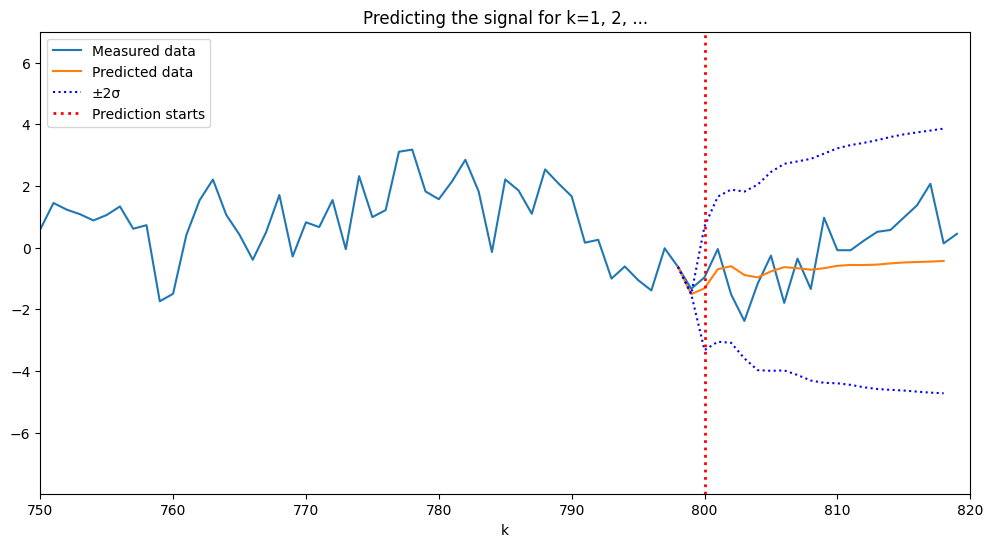

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(data[:pstart+kMax], label='Measured data')
plt.xlim([pstart-50, pstart+kMax])
indV = np.arange(pstart-2, pstart+kMax-1)
plt.plot(indV, pred_yk[indV], label='Predicted data')
plt.plot(indV, pred_yk[indV] + 2*np.sqrt(var_yk[indV]), 'b:', label='±2σ')
plt.plot(indV, pred_yk[indV] - 2*np.sqrt(var_yk[indV]), 'b:')
plt.axvline(x=pstart, color='red', linestyle=':', linewidth=2, label='Prediction starts')
plt.legend(loc='upper left')
plt.title('Predicting the signal for k=1, 2, ...')
plt.xlabel('k')
plt.show()

## Plot the theoretical variance

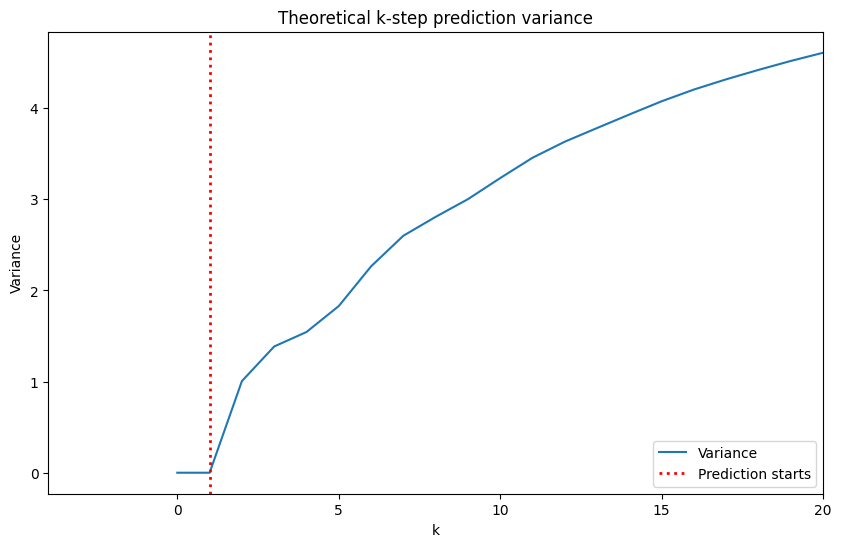

In [9]:
plt.figure(figsize=(10, 6))
indV = np.arange(pstart-2, pstart+kMax-1)
plt.plot(indV-pstart+2, var_yk[indV], label='Variance')
plt.axvline(x=1, color='red', linestyle=':', linewidth=2, label='Prediction starts')
plt.xlim([-4, kMax])
plt.title('Theoretical k-step prediction variance')
plt.xlabel('k')
plt.ylabel('Variance')
plt.legend(loc='lower right')
plt.show()